<a href="https://colab.research.google.com/github/lucaszm7/CNC_Aprox_SELAs_Interpol_IntegDiff/blob/main/Lucas_Morais_Relatorio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bibliotecas**


In [ ]:
#Bibliotecas Aqui!
import matplotlib.pyplot as plt
import numpy as np
import math
from sympy import *

### Função auxiliar para o plot das funções

In [ ]:
def plot_value_from_interpolation(m, x, y, z, interpol_method, n_ptos=100, Xlabel='X', Ylabel='Y', title='Questão XXX', colors=['blue', 'green', 'brown', 'orange', 'red'], extrapol=0):
  
  plt.scatter(x, y, c='black')

  innerpol = min(min(x), min(z))
  extrapol = max(max(x), max(z))

  curva = np.linspace(x[0], extrapol, n_ptos)
  for m_index in range(len(m)):
    valores = [interpol_method(m[m_index], x, y, k, 'value') for k in curva]

    line_label = str(m[m_index]) + ' grau'
    # color=colors[m_index], 
    plt.plot(curva, valores, linestyle='-', label=line_label)

  plt.xlabel(Xlabel)
  plt.ylabel(Ylabel)
  plt.title(title)
  plt.grid()

  plt.legend()
  plt.show()

In [ ]:
def plot_function_from_interpolation(m, x, y, z, interpol_method, n_ptos=100, Xlabel='X', Ylabel='Y', title='Questão XXX', colors=['blue', 'green', 'brown', 'orange', 'red']):
  plt.scatter(x, y, c='black')

  innerpol = min(min(x), min(z))
  extrapol = max(max(x), max(z))

  curva = np.linspace(innerpol, extrapol, n_ptos)

  for m_index in range(len(m)):

    expr = lambdify(symbols('z'), interpol_method(m[m_index], x, y, z[-1], 'function'), 'math')
    valores = [expr(k) for k in curva]
    line_label = (str(m[m_index]) + ' grau - para ' + str(z[-1]))
    plt.plot(curva, valores, linestyle='-', label=line_label)

  plt.xlabel(Xlabel)
  plt.ylabel(Ylabel)
  plt.title(title)
  plt.grid()

  plt.legend()
  plt.show()

In [ ]:
def plot_spline(x, y, interpol_method, n_ptos=100, Xlabel='X', Ylabel='Y', title='Questão XXX'):
  
  plt.scatter(x, y, c='red')

  curva = np.linspace(min(x), max(x), n_ptos)

  for i in range(len(x) - 1):
    expr = lambdify(symbols('x'), interpol_method(x, y)[i], 'math')
    valores = [expr(k) for k in curva]
    line_label = (str(i+1) + ' interval')
    plt.plot(curva, valores, linestyle='-', label=line_label)

  plt.xlabel(Xlabel)
  plt.ylabel(Ylabel)
  plt.title(title)
  plt.grid()

  plt.legend()
  plt.show()

In [ ]:
def plot_scatter_points(x, y, Xlabel='X', Ylabel='Y', color='cyan', title='Questão XXX'):

  plt.scatter(x, y, c=color)

  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(title)
  plt.grid()

  plt.show()

In [ ]:
def plot_squared_min(x, y, interpol_method, a_type, n_ptos=100, Xlabel='X', Ylabel='Y', title='Questão XXX'):
  
  plt.scatter(x, y, c='red')

  curva = np.linspace(min(x), max(x), n_ptos)

  for b_type in a_type:
    expr = lambdify(symbols('x'), interpol_method(x, y, b_type), 'math')
    valores = [expr(k) for k in curva]
    line_label = (b_type)
    plt.plot(curva, valores, linestyle='-', label=line_label)

  plt.xlabel(Xlabel)
  plt.ylabel(Ylabel)
  plt.title(title)
  plt.grid()

  plt.legend()
  plt.show()

### Funções auxiliares para truncar ou arredondar floats a uma certa precisão

In [ ]:
def truncate(number, decimals):
  factor = int(1 / decimals)
  trunc = math.trunc(number * factor)
  return (trunc / factor)

In [ ]:
def round_epsilon(number, precision):
  n_digits = int(1/precision)
  epsilon = math.log(n_digits, 10)
  return round(number, int(epsilon))

In [ ]:
def round_epsilon_array(number, precision):
  n_digits = int(1/precision)
  epsilon = math.log(n_digits, 10)
  return np.round(number, int(epsilon))

### Função auxiliar para retro substituição

In [ ]:
def retro_substituicao(matriz, b, n, triangular="superior", precisao=None):

  results = np.array([1] * n, dtype=np.float64)

  if triangular == "superior":
    if precisao is not None:
      for i in range( n-1, -1, -1 ):
        sum_of_line = round_epsilon(np.sum(matriz[i][i+1:n] * results[i+1:n], dtype=np.float64), precisao)
        results[i] = round_epsilon((b[i] - sum_of_line) / matriz[i][i], precisao)
      return results
    else:
      for i in range( n-1, -1, -1 ):
        sum_of_line = np.sum(matriz[i][i+1:n] * results[i+1:n], dtype=np.float64)
        results[i] = (b[i] - sum_of_line) / matriz[i][i]
      return results

  else: # inferior
    if precisao is not None:
      for i in range( 0, n, 1 ):
        sum_of_line = round_epsilon(np.sum(matriz[i][0:i] * results[0:i], dtype=np.float64), precisao)
        results[i] = round_epsilon((b[i] - sum_of_line) / matriz[i][i], precisao)
      return results
    else:
      for i in range( 0, n, 1 ):
        sum_of_line = np.sum(matriz[i][0:i] * results[0:i], dtype=np.float64)
        results[i] = (b[i] - sum_of_line) / matriz[i][i]
      return results

### Classe auxiliar para representação de máquinas

In [ ]:
class Maquina:
  def __init__(self, mantissa, base, menor_expoente, maior_expoente):
    self.mantissa = mantissa
    self.base = mantissa
    self.menor_expoente = menor_expoente
    self.maior_expoente = maior_expoente

## Função auxiliar, Eliminação de Gauss

In [ ]:
def retro_substituicao(matriz, b, n, triangular="superior", precisao=None):

  results = np.array([1] * n, dtype=np.float64)

  if triangular == "superior":
    if precisao is not None:
      for i in range( n-1, -1, -1 ):
        sum_of_line = round_epsilon(np.sum(matriz[i][i+1:n] * results[i+1:n], dtype=np.float64), precisao)
        results[i] = round_epsilon((b[i] - sum_of_line) / matriz[i][i], precisao)
      return results
    else:
      for i in range( n-1, -1, -1 ):
        sum_of_line = np.sum(matriz[i][i+1:n] * results[i+1:n], dtype=np.float64)
        results[i] = (b[i] - sum_of_line) / matriz[i][i]
      return results

  else: # inferior
    if precisao is not None:
      for i in range( 0, n, 1 ):
        sum_of_line = round_epsilon(np.sum(matriz[i][0:i] * results[0:i], dtype=np.float64), precisao)
        results[i] = round_epsilon((b[i] - sum_of_line) / matriz[i][i], precisao)
      return results
    else:
      for i in range( 0, n, 1 ):
        sum_of_line = np.sum(matriz[i][0:i] * results[0:i], dtype=np.float64)
        results[i] = (b[i] - sum_of_line) / matriz[i][i]
      return results

In [ ]:
def gauss_elimination(matriz, n, pivotamento="nenhum"):

# Escalonamento

  # Vai em todas colunas
  for j in range(0, n):

    # ==========================================================================
    # PIVOTAMENTO TOTAL
    # ==========================================================================
    if pivotamento == "total":
      # Seleciona como pivo o maior elementro da matriz
      maior_elemento = matriz[j][j]
      i_maior_elemento, j_maior_elemento = j, j

      # Vai procurar em toda matriz para encontrar o amior elemento
      for i in range(j, n, 1):
        for j_index in range(j, n, 1):
          if math.fabs(matriz[i][j_index]) > math.fabs(maior_elemento):
            i_maior_elemento, j_maior_elemento = i, j_index
            maior_elemento = matriz[i][j_index]

      # Swap rows
      matriz[[j, i_maior_elemento]] = matriz[[i_maior_elemento, j]]
      # Swap collums
      matriz[: , [j, j_maior_elemento]] = matriz[: , [j_maior_elemento, j]]

      pivo = matriz[j][j]
      if pivo == 0:
        print("Invalid matriz, collum j == 0...")
        return

    # ==========================================================================
    # PIVOTAMENTO PARCIAL
    # ==========================================================================
    elif pivotamento == "parcial":
      # Seleciona como pivo o maior elementro da coluna j
      # print("Matriz: \n", matriz)
      maior_elemento = matriz[j][j]
      for i in range(j+1, n, 1):
        # print("Maior elemento: ", maior_elemento)
        # print("Matriz[i][j]: ", matriz[i][j])
        if  math.fabs(matriz[i][j]) > math.fabs(maior_elemento):
          # Swap linha com maior elemento
          matriz[[i, j]] = matriz[[j, i]]
          # print("Matriz swapped: \n", matriz)
          maior_elemento = matriz[j][j]
    
      pivo = matriz[j][j]
      # print("Pivo: ", pivo)
      if pivo == 0:
        print("Invalid matriz, collum j == 0...")
        return

    # ==========================================================================
    # SEM PIVOTAMENTO
    # ==========================================================================
    elif pivotamento == "nenhum":
      # Seleciona pivo
      pivo = matriz[j][j]
      # print("pivo == ", pivo)
      # Swap com a próxima linha até pivo != 0
      index_pivo = j + 1
      while pivo == 0:
        # print("pivo == 0, swapping rows")
        matriz[[j, index_pivo]] = matriz[[index_pivo, j]]
        # print("Matrix swapped\n", matriz)
        pivo = matriz[j][j]
        # print("new pivo = ", pivo)
        index_pivo += 1
        if index_pivo > n:
          print("Invalid matriz...")
          return

    # pivotamento errado
    else:
      print("invalid pivotamento...")
      return

    # ==========================================================================
    # Constroi linha L'
    # Vai da linha j até a ultima
    for i in range(j+1, n):
      # Multiplicador da linha i
      m = matriz[i][j] / pivo
      # Linha L'i
      matriz[i] = matriz[i] - m * matriz[j]


# Retro Substituição

  # Pega b (os resultados)
  # fazendo a transposta da matriz
  b = matriz.T[n]

  # Retira a ultima coluna dos resultados
  matriz = matriz[0:n+1][0:n]

  # Cria o array (de tamanho n) que sera armazenado os resultados
  results = np.array([1] * n, dtype=np.float64)

  # Vai da ultima inha até a primeira
  for i in range( n-1, -1, -1 ):
      sum_of_line = np.sum(matriz[i][i+1:n] * results[i+1:n], dtype=np.float64)
      results[i] = (b[i] - sum_of_line) / matriz[i][i]

  return (matriz, results)

# **Métodos**

## *Forma de Lagrange*

In [ ]:
# grau, abscissas, ordenadas, valor a interpolar, retorna função ou valor em Z
def lagrange_interpolation(m, x, y, z, return_type):

  if m > len(x):
    raise ValueError("Desired dregree is bigger than number of points")

  # print('===========================================')
  # print('Desired value: ', z, ' - For ', m, ' degree')
  # print('raw X:         ', x)
  # print('raw Y:         ', y)

  x_index = 0
  for it in range(len(x) - 1):
    if x[it+1] >= z:
      x_index = it
      break
    else:
      x_index = it
  
  it_min = it_max = x_index  

  for k in range(0, m):
    if k%2 == 0:
      if (it_max + 1) > len(x):
        it_min -= 1
      else:
        it_max += 1
    else:
      if (it_min - 1) < 0:
        it_max += 1
      else:
        it_min -= 1
    
  x = x[it_min: it_max + 1]
  y = y[it_min: it_max + 1]

  m = len(x)
  # print('sliced X:      ', x)
  # print('sliced Y:      ', y)

  if return_type == 'function':
    z = symbols('z')
  elif return_type == 'value':
    z = z
  else:
    raise ValueError('Arg return_type is neither function or value')

  r = 0 # resultado
  for i in range(m):
    c = 1 # cociente
    d = 1 # dividendo
    for j in range(m):
      if i != j:
        c = c * (z - x[j])
        d = d * (x[i] - x[j])
    r = r + (y[i] * (c / d))
  return r

In [ ]:
# Teste Lagrange
lagrange_interpolation(2, [-1, 0, 2], [4, 1, -1], 1, 'value')

-0.6666666666666665

In [ ]:
lagrange_interpolation(2, [-1, 0, 2], [4, 1, -1], 1, 'function')

4*z*(z - 2)/3 - z*(z + 1)/6 - (z - 2)*(z + 1)/2

## *Forma de Newton*

In [ ]:
def d(x, y, m):
  if len(m) == 0:
    return 1
  elif len(m) == 1:
    return y[m[0]]
  else:
    # print('m: ', m)
    # print('m[1:-0]: ', m[1:len(m) + 1])
    # print('m[0:-1]: ', m[0:-1])
    return (d(x, y, m[1:len(m) + 1]) - d(x, y, m[0:-1])) / (x[m[-1]] - x[m[0]])

In [ ]:
# grau, abscissas, ordenadas, valor a interpolar
def newton_interpolation(m, x, y, z, return_type):

  if m > len(x):
    raise ValueError("Desired dregree is bigger than number of points")

  x_index = 0
  for it in range(len(x) - 1):
    if x[it+1] >= z:
      x_index = it
      break
    else:
      x_index = it

  it_min = it_max = x_index  

  for k in range(0, m):
    if k%2 == 0:
      if (it_max + 1) > len(x):
        it_min -= 1
      else:
        it_max += 1
    else:
      if (it_min - 1) < 0:
        it_max += 1
      else:
        it_min -= 1
    
  x = x[it_min: it_max + 1]
  y = y[it_min: it_max + 1]

  m = list(range(0, len(x)))

  if return_type == 'function':
    z = symbols('z')
  elif return_type == 'value':
    z = z
  else:
    raise ValueError('Arg return_type is neither function or value')

  r = 0
  di = 0
  dj = 1

  for i in range(len(m)):
    # print('=== i: ', i, ' ===')
    dj = 1
    di = d(x, y, m[0:i+1])
    # print('di: ', di)
    for j in range(i-1, -1, -1):
      dj *= (z - x[j])
      # print('dj: ', dj)
    r += di * dj
    # print('r: ', r)

  # print('Final result: ', r)
  return r

In [ ]:
# Teste Newton
newton_interpolation(3, [-1, 0, 2], [4, 1, -1], 1, 'value')

-0.6666666666666667

In [ ]:
newton_interpolation(3, [-1, 0, 2], [4, 1, -1], 1, 'function')

0.666666666666667*z*(z + 1) - 3.0*z + 1.0

## *Spline Cúbica Natural*

In [ ]:
def natural_cubic_spline(x, y):
  # Si(x) = ai + bi(x-xi) + ci(x-xi)^2 + di(x-xi)^3

  # 1º Propriedade de continuidade, passa por todos pontos
  # ai = f(xi)

  # 2º Propriedade, o valor das splines adjacentes a um mesmo nó, tem mesmo valor
  # f(xi+1) = f(xi) + bi*hi + ci*hi^2 + di*hi^3

  # 3º A derivada primeira em nós adjacentes deve ser igual
  # bi+1 = 3di*hi^2 + 2ci*hi + bi

  # 4º A derivada segunda em nós adjacentes deve ser igual
  # 2ci+1 = 6di*hi + 2ci

  # 5º Spline cúbica *NATURAL*, a derivada segunda nos nós extremos é 0
  # S1''(x1) = 2c1 + 6d1*h1 = 0
  # Sn-1''(xn-1) = 2cn-1 + 6dn-1*hn-1 = 0

  # =====================================================
  # Para cada subintervalo de 1 até n, teremos uma spline
  # ak = f(xk)
  # bk = (f(xk) - f(xk-1) / hk + (2hk*gk + gk-1*hk)) / 6
  # ck = gk/2
  # dk = (gk - gk-1) / 6*hk

  # Para achar os gk
  # hk*gk-1 + 2(hk-hk+1)gk + hk+1*gk+1 = 6((f(xk+1) - f(xk) / hk+1) - (f(xk) - f(xk-1)) / hk)
  
  # Onde
  # hk = xk - xk-1
  # g0 = gn-1 = 0
  # ======================================================

  if len(x) != len(y):
    raise ValueError("X and Y should be of same size")

  h = [None] * (len(x) - 1)
  g = []
  eq = [] 


  for k in range(0, len(h)):
    h[k] = x[k+1] - x[k]

  for k in range(0, len(x) - 2):

    for kn in range(k - 1):
      g.append(0)

    g.append(h[k])
    g.append(2 * (h[k] + h[k+1]))
    g.append(h[k+1])

    for kn in range(k + 2, (len(x) - 2), 1):
      g.append(0)

    g.append(6 * (((y[k+2] - y[k+1]) / h[k+1]) - ((y[k+1] - y[k]) / h[k])))

    eq.append(g)
    g = []

  
  eq[0].pop(0)
  eq[-1].pop(-2)

  matriz = np.array(eq)
  matriz, g = gauss_elimination(matriz, len(x) - 2, "parcial")
  
  g = np.insert(g, [0, len(g)], 0)

  w = symbols('x')
  s = []

  for i in range(len(x) - 1):
    ai = y[i+1]
    bi = ((y[i+1] - y[i]) / h[i] + (2*h[i]*g[i+1] + g[i]*h[i]) / 6) * (w - x[i+1])
    ci = (g[i+1]/2) * ((w - x[i+1])**2)
    di = ((g[i+1] - g[i]) / (6 * h[i])) * ((w - x[i+1])**3)
    # print('ai: ', ai)
    # print('bi: ', bi)
    # print('ci: ', ci)
    # print('di: ', di)
    s.append(ai + bi + ci + di)

  # print(eq)
  return s

In [ ]:
# Teste Spline Cubica
natural_cubic_spline([3.0, 4.5, 7.0, 9.0],[2.5, 1.0, 2.5, 0.5])

[-0.160456273764258*x + 17.0007604562738*(0.222222222222222*x - 1)**3 + 17.0007604562738*(0.222222222222222*x - 1)**2 + 1.72205323193916,
 0.0220532319391633*x - 73.4515589353612*(0.142857142857143*x - 1)**3 - 37.5604562737643*(0.142857142857143*x - 1)**2 + 2.34562737642586,
 -1.51102661596958*x + 93.1346007604563*(0.111111111111111*x - 1)**3 + 14.0992395437262]

In [ ]:
x = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
y = [0.841471,	0.891207,	0.932039,	0.963558,	0.985450,	0.997495,	0.999574,	0.991665]

s = natural_cubic_spline(x, y)
eq1 = lambdify(symbols('x'), s[0], 'math')
eq2 = lambdify(symbols('x'), s[1], 'math')
eq3 = lambdify(symbols('x'), s[2], 'math')

print(eq1(1))
print(eq2(1.12))
print(eq2(1.2))
print(eq3(1.35))

0.8414709999999996
0.9001892568079699
0.9320390000000003
0.9757235823170741


## *Método dos mínimos quadrados*

In [ ]:
def erro_quadratico(x, y, f):
  r = [f(z) for z in x]

  dif = [(a-b)**2 for a, b in zip(y, r)]

  dif_sum = sum(dif)

  dif_sum = sqrt(dif_sum)

  return dif_sum

In [ ]:
def squared_min(x, y, a_type='linear'):

  # Linear = ax + b
  # Quad = ax^2 + bx + c
  n = len(x)

  z = symbols('x')

  if a_type == 'exp':
    y = [math.log(a) for a in y]

  xy = [(a * b) for a, b in zip(x, y)]
  x2 = [(a**2) for a, in zip(x)]

  if a_type == 'quad':
    yx2 = [(a * b) for a, b in zip(x2, y)]
    x3 = [(a**3) for a, in zip(x)]
    x4 = [(a**4) for a, in zip(x)]

    r1 = [n, sum(x), sum(x2), sum(y)]
    r2 = [sum(x), sum(x2), sum(x3), sum(xy)]
    r3 = [sum(x2), sum(x3), sum(x4), sum(yx2)]

    m = np.array([r1, r2, r3])

    m, r = gauss_elimination(m, 3)
    c, b, a = r
    g = a*(z**2) + b*z + c

    return g

  for i in range(len(x)):
    a = (n * sum(xy) - sum(x) * sum(y)) / ( n * sum(x2) - (sum(x)**2) )
    b = ( ( sum(x) * sum(xy) - sum(y) * sum(x2) ) / ( (sum(x)**2) - n * sum(x2) ) )

  if a_type == 'linear':
    g = a*z + b
  
  elif a_type == 'exp':
    b = exp(b)
    g = b * exp(a*z)

  return g

In [ ]:
# Teste squared_min
x = [1, 2, 3, 4]
y = [3, 5, 6, 8]
squared_min(x, y, 'linear')

1.6*x + 1.5

In [ ]:
squared_min(x, y, 'exp')

2.37170824512629*exp(0.312480931582913*x)

In [ ]:
x = [-1, 0, 1, 2]
y = [1, -1, 2, 3]
squared_min(x, y, 'quad')

0.75*x**2 + 0.05*x + 0.1

In [ ]:
x = [-1, 0, 1, 2]
y = [1, -1, 2, 3]
squared_min(x, y, 'linear')

0.9*x + 0.8

In [ ]:
erro_quadratico(x, y, lambdify(symbols('x'), squared_min(x, y, 'linear'), 'math'))

2.16794833886788

# **Relatório 3**


##Questão 1 –
Considere os dados

x    1 2 3   5  6 

f(x) 7 4 5,5 40 82

a) Calcule f(4) usando polinômios interpoladores de Newton de primeiro a quarto graus. Escolha seus pontos-base para obter uma boa acurácia; ou seja, os pontos devem ser centrados em torno e tão próximo quanto possível do valor desconhecido. O que seus resultados indicam em relação ao grau do polinômio usado para gerar os dados da tabela?

b) Repita (a), mas utilize polinômios de Lagrange.

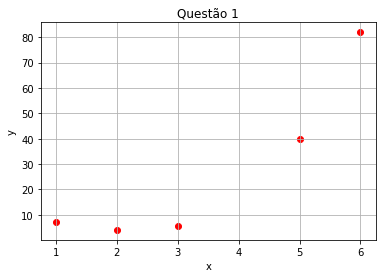

In [ ]:
plot_scatter_points([1, 2, 3, 5, 6], [7, 4, 5.5, 40, 82], color='r', title='Questão 1')

### Resposta da questão 1

Quanto maior o grau do polinomio interpolador mais a a curva se ajusta aos pontos, então com um polinomio de grau igual ao numero de pontos tabelados - 1 temos a maior acurácia possivel para os pontos tabelados. Mas pode acontecer de um polinômio de grau inferior já se adequar completamente ao dado conjunto de pontos

### **a)**

In [ ]:
for i in range(4):
  expr = lambdify(symbols('z'), newton_interpolation(i+1, [1, 2, 3, 5, 6], [7, 4, 5.5, 40, 82], 4, 'function'), 'math')
  print(expr(4))

22.75
17.5
16.0
16.0


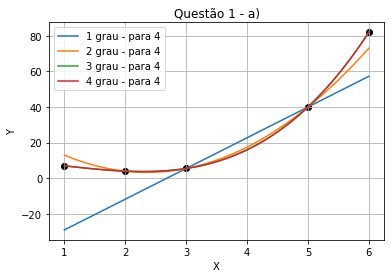

In [ ]:
plot_function_from_interpolation([1, 2, 3, 4], [1, 2, 3, 5, 6], [7, 4, 5.5, 40, 82], [4], newton_interpolation, title='Questão 1 - a)')

### **b)**

In [ ]:
for i in range(4):
  expr = lambdify(symbols('z'), lagrange_interpolation(i+1, [1, 2, 3, 5, 6], [7, 4, 5.5, 40, 82], 4, 'function'), 'math')
  print(expr(4))

22.75
17.5
16.0
15.999999999999996


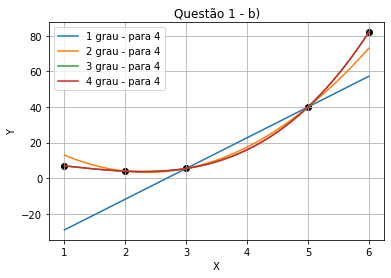

In [ ]:
plot_function_from_interpolation([1, 2, 3, 4], [1, 2, 3, 5, 6], [7, 4, 5.5, 40, 82], [4], lagrange_interpolation, n_ptos=100, title='Questão 1 - b)')

##Questão 2 –
 Os dados contidos na tabela abaixo relacionam o peso (y) de embriões de frangos desidratados, em gramas, com sua idade (x) em dias.

 x(dias) 6 7 8 9 10 11 12 13 14 15 16

 y 0,029 0,052 0,079 0,125 0,181 0,261 0,425 0,738 1,130 1,882 2,812

a) Trace o diagrama de dispersão do conjunto de dados.

b) Efetue o ajuste polinomial para o conjunto. Para isso, encontre os ajustes até o polinômio de grau cinco. Usando Newton ou Lagrange.

c) Trace o gráfico da curva que representa o melhor ajuste.

d) Estime o peso de um embrião de frango no 20o dia de vida.

In [ ]:
x = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
y = [0.029, 0.052, 0.079, 0.125, 0.181, 0.261, 0.425, 0.738, 1.130, 1.882, 2.812]

### **a)**

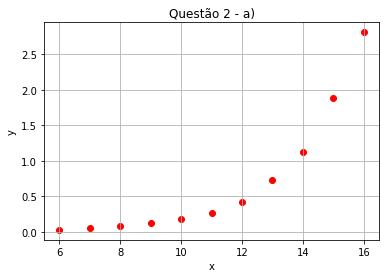

In [ ]:
plot_scatter_points(x, y, 'Dias', 'Peso em g', 'r', 'Questão 2 - a)')

### **b)**

### Resposta da Questão 2 - b)

Aqui é usado o ponto médio do conjunto a fim de ter uma representação mais justa

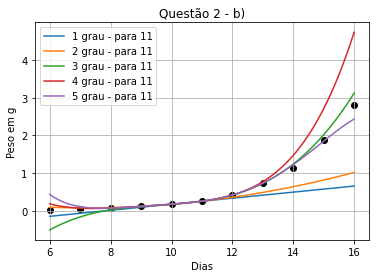

In [ ]:
plot_function_from_interpolation([1, 2, 3, 4, 5], x, y, [11], newton_interpolation, 100, 'Dias', 'Peso em g', title='Questão 2 - b)')

### **c)**

### Resposta da Questão 2 - c)

O grau que possui a melhor aproximação centrado no ponto 11 é o polinomio de grau 5, pois possui menor erro quadratico

In [ ]:
erro_quadratico(x, y, lambdify(symbols('z'), newton_interpolation(1, x, y, 11, 'function'), 'math'))

2.62051006485379

In [ ]:
erro_quadratico(x, y, lambdify(symbols('z'), newton_interpolation(2, x, y, 11, 'function'), 'math'))

2.15376902197055

In [ ]:
erro_quadratico(x, y, lambdify(symbols('z'), newton_interpolation(3, x, y, 11, 'function'), 'math'))

0.672161438941567

In [ ]:
erro_quadratico(x, y, lambdify(symbols('z'), newton_interpolation(4, x, y, 11, 'function'), 'math'))

2.12538961134187

In [ ]:
erro_quadratico(x, y, lambdify(symbols('z'), newton_interpolation(5, x, y, 11, 'function'), 'math'))

0.568782911135695

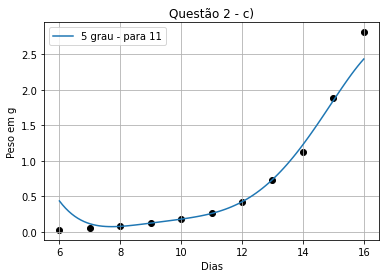

In [ ]:
plot_function_from_interpolation([5], x, y, [11], newton_interpolation, 100, 'Dias', 'Peso em g', title='Questão 2 - c)')

### **d)**

In [ ]:
newton_interpolation(5, x, y, 20, 'value')

-11.533000000000015

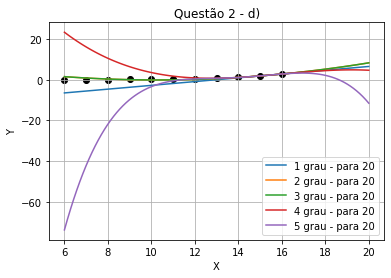

In [ ]:
plot_function_from_interpolation([1, 2, 3, 4, 5], x, y, [20], newton_interpolation, 100, title='Questão 2 - d)')

## Questão 3 – 

Os dados a seguir definem a concentração de oxigênio dissolvido na água fresca em função da temperatura no nível do mar:

T,oC 0 8 16 24 32 40

o, mg/L 14,621 11,843 9,870 8,418 7,305 6,413

Estime o(27) usando spline cúbica natural. Observe que o resultado exato é 7,986 mg/L.


In [ ]:
x = [0, 8, 16, 24, 32, 40]
y = [14.621, 11.843, 9.870, 8.418, 7.305, 6.413]

s = natural_cubic_spline(x, y)

eq4 = lambdify(symbols('x'), s[3], 'math')

eq4(27)

7.9657088722338845

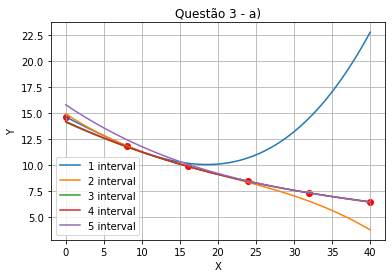

In [ ]:
plot_spline(x, y, natural_cubic_spline, title='Questão 3 - a)')

##Questão 4 – 
Os dados a seguir representam o crescimento bacteriológico em uma cultura liquida durante um certo número de dias:

Dia 0 4 8 12 16 20 

Quantidade x 10^6 67,38 74,67 82,74 91,69 101,60 112,58 

Encontre a equação do melhor ajuste para a tendência dos dados. Use a regressão por mínimos quadrados com as seguintes possibilidades – linear, quadrática e exponencial. Determine a melhor equação para prever a quantidade de bactérias após 30 dias.


In [ ]:
x = [0, 4, 8, 12, 16, 20]
y = [67.38, 74.67, 82.74, 91.69, 101.60, 112.58]

In [ ]:
erro_quadratico(x, y, lambdify(symbols('x'), squared_min(x, y, 'linear'), 'math'))

2.81892009042301

In [ ]:
erro_quadratico(x, y, lambdify(symbols('x'), squared_min(x, y, 'quad'), 'math'))

0.126018706094438

In [ ]:
erro_quadratico(x, y, lambdify(symbols('x'), squared_min(x, y, 'exp'), 'math'))

0.00637638276551390

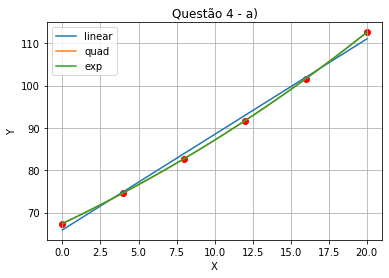

In [ ]:
plot_squared_min(x, y, squared_min, ['linear', 'quad', 'exp'], title='Questão 4 - a)')

### Resposta da questão 4
A melhor equação para prever a quantidade de bacterias após 30 dias é a regressão exponencial 
 - ( 67.382526651699e 0.0256656054400444x ).
 
Pois apresenta o menor erro quadratico:

In [ ]:
squared_min(x, y, 'exp')

67.382526651699*exp(0.0256656054400444*x)